In [1]:
%%capture
from datasets import load_dataset

dataset = load_dataset("scaredmeow/shopee-reviews-tl-binary")


In [2]:
%%capture
import wandb

# initialize wandb
wandb.init(project="xlnet-finetuning", name="5th-run")

In [4]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

pretrained = "../models/finetuned_model"
tokenizer = AutoTokenizer.from_pretrained(pretrained)


model = AutoModelForSequenceClassification.from_pretrained(pretrained, num_labels=2).to(
    "cuda"
)


In [5]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )



In [ ]:

tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(350))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(150))


In [24]:
from collections import Counter

small_train_dataset.select(range(5))
Counter(small_train_dataset.select(range(350))["label"])


Counter({1: 179, 0: 171})

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="../models/fine-tuned-roberta",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_steps=1000,
    logging_steps=500,
    save_total_limit=2,
    num_train_epochs=3,
    seed=42,
    logging_dir="./logs",
    eval_steps=500,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [26]:
trainer.train()


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.36863255500793457, 'eval_accuracy': 0.8933333333333333, 'eval_runtime': 6.56, 'eval_samples_per_second': 22.866, 'eval_steps_per_second': 5.793, 'epoch': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.4188827574253082, 'eval_accuracy': 0.92, 'eval_runtime': 6.6192, 'eval_samples_per_second': 22.661, 'eval_steps_per_second': 5.741, 'epoch': 2.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.7059031128883362, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 6.6343, 'eval_samples_per_second': 22.61, 'eval_steps_per_second': 5.728, 'epoch': 3.0}
{'train_runtime': 169.9167, 'train_samples_per_second': 6.179, 'train_steps_per_second': 1.554, 'train_loss': 0.2490476839470141, 'epoch': 3.0}


TrainOutput(global_step=264, training_loss=0.2490476839470141, metrics={'train_runtime': 169.9167, 'train_samples_per_second': 6.179, 'train_steps_per_second': 1.554, 'train_loss': 0.2490476839470141, 'epoch': 3.0})

In [27]:
trainer.save_model("../models/fine-tuned-roberta-1st-iter")
tokenizer.save_pretrained("../models/fine-tuned-roberta-1st-iter")


('../models/fine-tuned-roberta-1st-iter\\tokenizer_config.json',
 '../models/fine-tuned-roberta-1st-iter\\special_tokens_map.json',
 '../models/fine-tuned-roberta-1st-iter\\vocab.json',
 '../models/fine-tuned-roberta-1st-iter\\merges.txt',
 '../models/fine-tuned-roberta-1st-iter\\added_tokens.json',
 '../models/fine-tuned-roberta-1st-iter\\tokenizer.json')

In [28]:
dataset = tokenized_datasets["validation"]


In [29]:
pred = trainer.predict(dataset).predictions


  0%|          | 0/1500 [00:00<?, ?it/s]

In [30]:
y_pred = np.argmax(pred, axis=1).tolist()
y_true = dataset["label"]


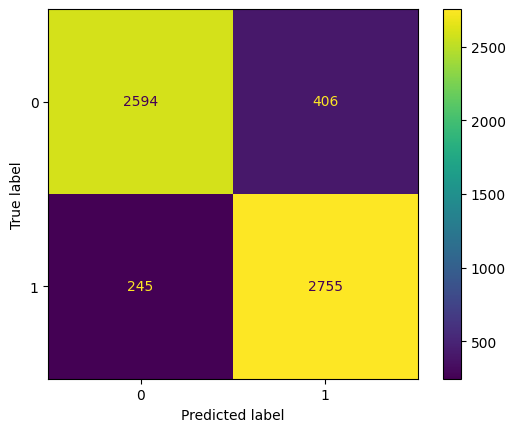

Accuracy: 0.8915
Precision: 0.8926308203883653
Recall: 0.8915
F1 score: 0.8914218206948398


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

# Compute the accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Compute the precision
prec = precision_score(y_true, y_pred, average="macro")
print("Precision:", prec)

# Compute the recall
rec = recall_score(y_true, y_pred, average="macro")
print("Recall:", rec)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average="macro")
print("F1 score:", f1)

# # Compute the log-loss
# ll = log_loss(y_true, y_pred, labels=[0, 1, 2, 3, 4])
# print("Log-loss:", ll)

# # Compute the AUC-ROC
# auc = roc_auc_score(y_true, y_pred, average="macro", multi_class="ovr")
# print("AUC-ROC:", auc)